<div>
    <h1 style="float: left">Tractor - Model Exploration and Selection
        <img src="https://reservations.ryder.com/-/media/reservation/images/vehicleimages/sleeper/08a_sleeper.ashx" width="200" height="100%" style="display: inline">
    </h1>
</div>

<hr />

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

In `averaging methods`, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

*Examples*: Bagging methods, Forests of randomized trees, …

By contrast, in `boosting methods`, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

*Examples*: AdaBoost, Gradient Tree Boosting, …

<hr />

**Gradient Tree Boosting** or **Gradient Boosted Regression Trees (GBRT)** is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

The advantages of GBRT are:

- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

- Scalability, due to the sequential nature of boosting it can hardly be parallelized.


Gradient boosting involves three elements:

- A loss function to be optimized
  -- Using Squared Error
- A weak learner to make predictions
  -- Decision trees are used as weak learners
- An additive model to add weak learners to minimize the loss function
  -- Trees are added one at a time, and existing trees in the model are not changed.
  -- A gradient descent procedure is used to minimize the loss when adding trees.



In [1]:
#!pip install xgboost --user
#!pip install lightgbm --user
#!pip install sklearn_pandas --user

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab
import pickle
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from xgboost import plot_tree

from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score

import xgboost as xgb
import lightgbm as lgb

### Load Data to use

In [3]:
df = pd.read_pickle('../../data/df_tractor.pickle')
df.shape

(23806, 30)

### Data Desription

In [4]:
#Use to supress scientific notation for numbers
pd.options.display.float_format = '{:,.2f}'.format
df.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
accumulated_depreciation_amt,"23,806.00",NaN,NaN,NaN,NaN,NaN,"56,905.75","12,120.66","19,546.00","48,388.75","55,085.00","63,895.25","149,900.00"
vehicle_sam_class_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,146.90,15.43,130.00,140.00,140.00,170.00,170.00
sam_summary_class_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,323.04,4.60,320.00,320.00,320.00,330.00,330.00
veh_domicle_location_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,"2,748.48",396.15,"1,328.00","2,443.00","2,686.00","3,172.00","3,452.00"
vehicle_disp_cond_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,14.81,12.18,10.00,10.00,10.00,10.00,50.00
days_to_outservice,"23,806.00",NaN,NaN,NaN,NaN,NaN,63.61,54.52,0.00,26.00,50.00,87.00,295.00
vehicle_age,"23,806.00",NaN,NaN,NaN,NaN,NaN,92.94,17.31,30.00,83.00,94.00,108.00,115.00
vehicle_gvw_class_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,7.98,0.22,1.00,8.00,8.00,8.00,8.00
drive_tire_size_cd,"23,806.00",NaN,NaN,NaN,NaN,NaN,"1,034.22",209.78,123.00,"1,102.00","1,102.00","1,102.00","1,446.00"
rear_axle_capacity,"23,806.00",NaN,NaN,NaN,NaN,NaN,"36,238.76","7,183.86","2,300.00","40,000.00","40,000.00","40,000.00","48,000.00"


## Modeling


### Step 1: Transform and Encode columns

#### Split Data Types

In [5]:
# Numerical Values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64']
df_num = df.select_dtypes(include=numerics)
df_num = df_num.fillna(0)
df_num.head(3)

,accumulated_depreciation_amt,vehicle_sam_class_cd,sam_summary_class_cd,veh_domicle_location_cd,vehicle_disp_cond_cd,days_to_outservice,vehicle_age,vehicle_gvw_class_cd,drive_tire_size_cd,rear_axle_capacity,...,year_month_num,net_vehicle_invest,proceeds,model_year,odomoter_sale,accpt_date_num,sale_date_num,accpt_date_ts,year_month_ts,sale_date_ts
1,"47,657.00",140,320,2438,10.00,5,100,8,472.00,"40,000.00",...,201401,68497,23000,2006,345180,201306,201401,2013-06-05,2014-01-01,2014-01-31
2,"53,383.00",170,330,2389,10.00,27,88,8,"1,102.00","40,000.00",...,201404,67821,30499,2007,589129,201403,201404,2014-03-05,2014-04-01,2014-04-17
5,"57,999.00",170,330,3408,10.00,112,88,8,"1,102.00","40,000.00",...,201401,72228,20000,2007,818626,201401,201401,2014-01-17,2014-01-01,2014-01-16


##### Drop redundant/non-needed columns

In [6]:
del df_num['accpt_date_ts']
del df_num['year_month_ts']
del df_num['year_month_num']
del df_num['sale_date_ts']


In [7]:
#Categorical Values
df_cat = df.select_dtypes(include=['object'])
categorical_features = df_cat.columns.tolist()
df_cat.head(3)

,suspension_type_cd,transmission_manufacturer_cd,engine_manufacturer_cd,model_mfg,epa_tech_year
1,A,FULL,CAT,OTHER,2004
2,A,FULL,DETR,FRTL,2004
5,A,FULL,DETR,FRTL,2004


#### Create Transformers

##### **`OneHotEncoder()`** converts each class under a categorical feature, a new column is created for it.

- In the latest version of Sklearn, OneHotEncoder will automatically converts each class under specified feature to a numerical value as would be done using `LabelEncoder()` first. This eliminates the need for a **two step process** as with previous versions
- Encode categorical integer features using a one-hot aka one-of-K scheme.
- The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.
- The output will be a sparse matrix where each column corresponds to one possible value of one feature.
- It is assumed that input features take on values in the range [0, n_values) This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels

In [8]:
# encoder = OneHotEncoder()
# df_cat_encoded = pd.DataFrame(encoder.fit_transform(df_cat).todense(), 
#                                 columns=encoder.get_feature_names())
encoder = OneHotEncoder()
df_cat_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features]).todense(), 
                                columns=encoder.get_feature_names(categorical_features))

In [9]:
encoder.get_feature_names(categorical_features)

array(['suspension_type_cd_A', 'suspension_type_cd_L',
       'suspension_type_cd_T', 'transmission_manufacturer_cd_ALLI',
       'transmission_manufacturer_cd_FULL',
       'transmission_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT',
       'engine_manufacturer_cd_CUMM', 'engine_manufacturer_cd_DETR',
       'engine_manufacturer_cd_INTL', 'engine_manufacturer_cd_OTHER',
       'model_mfg_FRTL', 'model_mfg_INTL', 'model_mfg_OTHER',
       'epa_tech_year_2002', 'epa_tech_year_2004', 'epa_tech_year_2007',
       'epa_tech_year_2010', 'epa_tech_year_2013', 'epa_tech_year_2014',
       'epa_tech_year_UNKNOWN'], dtype=object)

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
df_cat_encoded.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
suspension_type_cd_A,"23,806.00",0.96,0.20,0.00,1.00,1.00,1.00,1.00
suspension_type_cd_L,"23,806.00",0.04,0.20,0.00,0.00,0.00,0.00,1.00
suspension_type_cd_T,"23,806.00",0.00,0.05,0.00,0.00,0.00,0.00,1.00
transmission_manufacturer_cd_ALLI,"23,806.00",0.05,0.23,0.00,0.00,0.00,0.00,1.00
transmission_manufacturer_cd_FULL,"23,806.00",0.93,0.25,0.00,1.00,1.00,1.00,1.00
transmission_manufacturer_cd_OTHER,"23,806.00",0.02,0.12,0.00,0.00,0.00,0.00,1.00
engine_manufacturer_cd_CAT,"23,806.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00
engine_manufacturer_cd_CUMM,"23,806.00",0.27,0.44,0.00,0.00,0.00,1.00,1.00
engine_manufacturer_cd_DETR,"23,806.00",0.58,0.49,0.00,0.00,1.00,1.00,1.00
engine_manufacturer_cd_INTL,"23,806.00",0.04,0.20,0.00,0.00,0.00,0.00,1.00


In [11]:
df_num.reset_index(drop=True, inplace=True)
df_cat_encoded.reset_index(drop=True, inplace=True)
df_main = pd.concat([df_num,df_cat_encoded], axis=1)
#df_main = df_main.reindex()

In [12]:
print(df_main.shape)
print(len(df_main) - df_main.count())

(23806, 42)
accumulated_depreciation_amt          0
vehicle_sam_class_cd                  0
sam_summary_class_cd                  0
veh_domicle_location_cd               0
vehicle_disp_cond_cd                  0
days_to_outservice                    0
vehicle_age                           0
vehicle_gvw_class_cd                  0
drive_tire_size_cd                    0
rear_axle_capacity                    0
transmission_model_id                 0
engine_model_id                       0
engine_horsepower                     0
transmission_speed_qn                 0
axle_total_count                      0
net_vehicle_invest                    0
proceeds                              0
model_year                            0
odomoter_sale                         0
accpt_date_num                        0
sale_date_num                         0
suspension_type_cd_A                  0
suspension_type_cd_L                  0
suspension_type_cd_T                  0
transmission_manufacturer_cd

In [13]:
pd.set_option('display.max_columns', None)
df_main[df_main.isin([np.nan, np.inf, -np.inf]).any(1)].head(50)

,accumulated_depreciation_amt,vehicle_sam_class_cd,sam_summary_class_cd,veh_domicle_location_cd,vehicle_disp_cond_cd,days_to_outservice,vehicle_age,vehicle_gvw_class_cd,drive_tire_size_cd,rear_axle_capacity,transmission_model_id,engine_model_id,engine_horsepower,transmission_speed_qn,axle_total_count,net_vehicle_invest,proceeds,model_year,odomoter_sale,accpt_date_num,sale_date_num,suspension_type_cd_A,suspension_type_cd_L,suspension_type_cd_T,transmission_manufacturer_cd_ALLI,transmission_manufacturer_cd_FULL,transmission_manufacturer_cd_OTHER,engine_manufacturer_cd_CAT,engine_manufacturer_cd_CUMM,engine_manufacturer_cd_DETR,engine_manufacturer_cd_INTL,engine_manufacturer_cd_OTHER,model_mfg_FRTL,model_mfg_INTL,model_mfg_OTHER,epa_tech_year_2002,epa_tech_year_2004,epa_tech_year_2007,epa_tech_year_2010,epa_tech_year_2013,epa_tech_year_2014,epa_tech_year_UNKNOWN


### Step 2: Define the X and Y variables

In [14]:
X = df_main.loc[:, df_main.columns != 'proceeds']
y = df_main['proceeds'].values
variables = df_main.columns[1:]
print(variables)


Index(['vehicle_sam_class_cd', 'sam_summary_class_cd',
       'veh_domicle_location_cd', 'vehicle_disp_cond_cd', 'days_to_outservice',
       'vehicle_age', 'vehicle_gvw_class_cd', 'drive_tire_size_cd',
       'rear_axle_capacity', 'transmission_model_id', 'engine_model_id',
       'engine_horsepower', 'transmission_speed_qn', 'axle_total_count',
       'net_vehicle_invest', 'proceeds', 'model_year', 'odomoter_sale',
       'accpt_date_num', 'sale_date_num', 'suspension_type_cd_A',
       'suspension_type_cd_L', 'suspension_type_cd_T',
       'transmission_manufacturer_cd_ALLI',
       'transmission_manufacturer_cd_FULL',
       'transmission_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT',
       'engine_manufacturer_cd_CUMM', 'engine_manufacturer_cd_DETR',
       'engine_manufacturer_cd_INTL', 'engine_manufacturer_cd_OTHER',
       'model_mfg_FRTL', 'model_mfg_INTL', 'model_mfg_OTHER',
       'epa_tech_year_2002', 'epa_tech_year_2004', 'epa_tech_year_2007',
       'epa_tech_year

In [15]:
print(X.columns)

Index(['accumulated_depreciation_amt', 'vehicle_sam_class_cd',
       'sam_summary_class_cd', 'veh_domicle_location_cd',
       'vehicle_disp_cond_cd', 'days_to_outservice', 'vehicle_age',
       'vehicle_gvw_class_cd', 'drive_tire_size_cd', 'rear_axle_capacity',
       'transmission_model_id', 'engine_model_id', 'engine_horsepower',
       'transmission_speed_qn', 'axle_total_count', 'net_vehicle_invest',
       'model_year', 'odomoter_sale', 'accpt_date_num', 'sale_date_num',
       'suspension_type_cd_A', 'suspension_type_cd_L', 'suspension_type_cd_T',
       'transmission_manufacturer_cd_ALLI',
       'transmission_manufacturer_cd_FULL',
       'transmission_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT',
       'engine_manufacturer_cd_CUMM', 'engine_manufacturer_cd_DETR',
       'engine_manufacturer_cd_INTL', 'engine_manufacturer_cd_OTHER',
       'model_mfg_FRTL', 'model_mfg_INTL', 'model_mfg_OTHER',
       'epa_tech_year_2002', 'epa_tech_year_2004', 'epa_tech_year_2007',
 

### Step 3: Create Training and Testing Dataframes

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1234)
print(X_train.shape, X_test.shape)

(11903, 41) (11903, 41)


### Step 4: Check regression model with 500 trees of depth 3 using least-squares

In [17]:
params = {'n_estimators': 500, 'max_depth': 3,'loss': 'ls'}

model_gbr = GradientBoostingRegressor(**params)
model_gbr.fit(X_train, y_train)
# predict class labels
pred = model_gbr.predict(X_test)

#### Setup variales to load Model Measures

In [18]:
MAE = {}
MSE = {}
SCORE = {}

**Mean Absolute Error (MAE):** 

MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

In [19]:
MAE["GBRE_ALL"] = mean_absolute_error(y_test, model_gbr.predict(X_test))
print('MAE: %.4f' % MAE["GBRE_ALL"])


MAE: 2734.9891


**The Mean Squared Error (MSE):**

MSE is a measure of how close a fitted line is to data points. For every data point, you take the distance vertically from the point to the corresponding y value on the curve fit (the error), and square the value. 

In [20]:
MSE["GBRE_ALL"] = mean_squared_error(y_test, model_gbr.predict(X_test))
print('MSE: %.4f' % MSE["GBRE_ALL"])


MSE: 14230223.3814


**Accuracy:**

Accuracy refers to the closeness of a measured value to a standard or known value. For example, if in lab you obtain a weight measurement of 3.2 kg for a given substance, but the actual or known weight is 10 kg, then your measurement is not accurate. In this case, your measurement is not close to the known value.

In [21]:
# score on test data (accuracy)
SCORE["GBRE_ALL"] =  model_gbr.score(X_test, y_test)
print('Accuracy: %.4f' % SCORE["GBRE_ALL"])


Accuracy: 0.8572


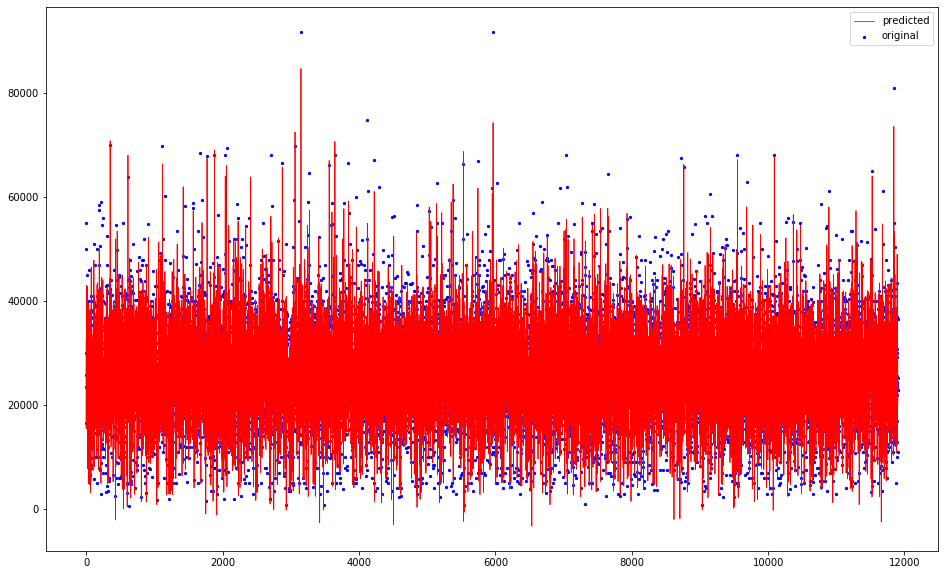

In [22]:
x_ax = range(len(y_test))
plt.figure(figsize=(16,10))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, model_gbr.predict(X_test), lw=0.8, color="red", label="predicted",)
plt.legend()
plt.show()

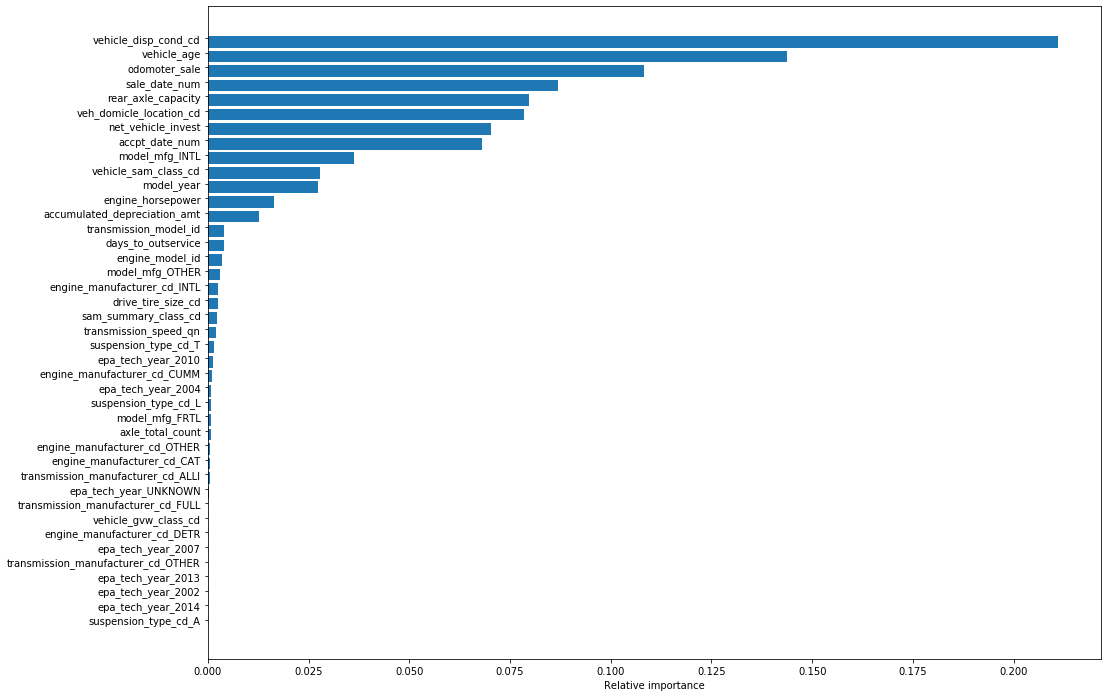

In [23]:
names = X.columns #variables.values
# sort importances
indices = np.argsort(model_gbr.feature_importances_)
# plot as bar chart
figure(figsize=(16,12))
plt.barh(np.arange(len(names)), model_gbr.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

In [24]:
indices = np.argsort(-model_gbr.feature_importances_)
names = X.columns
result = (np.array(names)[indices])
print(list(result))

['vehicle_disp_cond_cd', 'vehicle_age', 'odomoter_sale', 'sale_date_num', 'rear_axle_capacity', 'veh_domicle_location_cd', 'net_vehicle_invest', 'accpt_date_num', 'model_mfg_INTL', 'vehicle_sam_class_cd', 'model_year', 'engine_horsepower', 'accumulated_depreciation_amt', 'transmission_model_id', 'days_to_outservice', 'engine_model_id', 'model_mfg_OTHER', 'engine_manufacturer_cd_INTL', 'drive_tire_size_cd', 'sam_summary_class_cd', 'transmission_speed_qn', 'suspension_type_cd_T', 'epa_tech_year_2010', 'engine_manufacturer_cd_CUMM', 'epa_tech_year_2004', 'suspension_type_cd_L', 'model_mfg_FRTL', 'axle_total_count', 'engine_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT', 'transmission_manufacturer_cd_ALLI', 'epa_tech_year_UNKNOWN', 'transmission_manufacturer_cd_FULL', 'vehicle_gvw_class_cd', 'engine_manufacturer_cd_DETR', 'epa_tech_year_2007', 'transmission_manufacturer_cd_OTHER', 'epa_tech_year_2013', 'epa_tech_year_2002', 'epa_tech_year_2014', 'suspension_type_cd_A']


### Plot Deviance

Text(0, 0.5, 'Deviance')

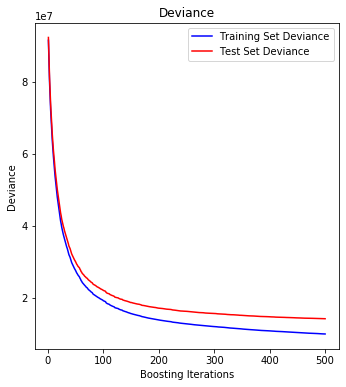

In [25]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model_gbr.staged_predict(X_test)):
    test_score[i] = model_gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model_gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

### Step 5: Rerun the model, but this time with only the most important variables

In [26]:
# keep = np.array(names)[indices].tolist()
# print(keep)
keep = []
importances = model_gbr.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    keep.append(np.array(names)[indices[f]])
print(keep)

['vehicle_disp_cond_cd', 'vehicle_age', 'odomoter_sale', 'sale_date_num', 'rear_axle_capacity', 'veh_domicle_location_cd', 'net_vehicle_invest', 'accpt_date_num', 'model_mfg_INTL', 'vehicle_sam_class_cd', 'model_year', 'engine_horsepower', 'accumulated_depreciation_amt', 'transmission_model_id', 'days_to_outservice', 'engine_model_id', 'model_mfg_OTHER', 'engine_manufacturer_cd_INTL', 'drive_tire_size_cd', 'sam_summary_class_cd', 'transmission_speed_qn', 'suspension_type_cd_T', 'epa_tech_year_2010', 'engine_manufacturer_cd_CUMM', 'epa_tech_year_2004', 'suspension_type_cd_L', 'model_mfg_FRTL', 'axle_total_count', 'engine_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT', 'transmission_manufacturer_cd_ALLI', 'epa_tech_year_UNKNOWN', 'transmission_manufacturer_cd_FULL', 'vehicle_gvw_class_cd', 'engine_manufacturer_cd_DETR', 'epa_tech_year_2007', 'transmission_manufacturer_cd_OTHER', 'epa_tech_year_2013', 'epa_tech_year_2002', 'epa_tech_year_2014', 'suspension_type_cd_A']


In [27]:
p = 'proceeds'
keep = [p]+keep[:10]
df_imp_feat = df_main[keep]

In [28]:
observations2 = len(df_imp_feat)

# X = df_main.iloc[:,:46]
X2 = df_imp_feat.loc[:, df_imp_feat.columns != 'proceeds']
y2 = df_imp_feat['proceeds'].values
variables2 = df_imp_feat.columns[:-1]
print(variables2)

Index(['proceeds', 'vehicle_disp_cond_cd', 'vehicle_age', 'odomoter_sale',
       'sale_date_num', 'rear_axle_capacity', 'veh_domicle_location_cd',
       'net_vehicle_invest', 'accpt_date_num', 'model_mfg_INTL'],
      dtype='object')


In [29]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2) 
print(X_train2.shape, X_test2.shape)

(17854, 10) (5952, 10)


In [30]:
params = {'n_estimators': 500, 'max_depth': 3,'loss': 'ls'}

# clf = ensemble.GradientBoostingRegressor(**params)
model_gbr2 = GradientBoostingRegressor(**params)
model_gbr2.fit(X_train2, y_train2)
# predict class labels
pred2 = model_gbr2.predict(X_test2)

### Check results

In [31]:
MAE["GBRE_TOP"] = mean_absolute_error(y_test2, model_gbr2.predict(X_test2))
MSE["GBRE_TOP"] = mean_squared_error(y_test2, model_gbr2.predict(X_test2))
SCORE["GBRE_TOP"] = model_gbr2.score(X_test2, y_test2)
print('MAE: %.4f' % MAE["GBRE_TOP"])
print('MSE: %.4f' % MSE["GBRE_TOP"])
print('Accuracy: %.4f' % SCORE["GBRE_TOP"])

MAE: 2850.9278
MSE: 15543216.8275
Accuracy: 0.8414


### Step 6: Check Feature Importance
Most of the features do not contribute equally to predict the target response (PROCEEDS). 
When interpreting a model, the first question usually is: what are those important features and how do they contributing in predicting the target response? Below we see the feature imporance based on the 3000 iterations from the previous model fit.

In [32]:
model_gbr2.feature_importances_

array([0.21036673, 0.15877892, 0.11261817, 0.09739243, 0.10190785,
       0.08244786, 0.08307851, 0.08283912, 0.04072385, 0.02984656])

Index(['vehicle_disp_cond_cd', 'vehicle_age', 'odomoter_sale', 'sale_date_num',
       'rear_axle_capacity', 'veh_domicle_location_cd', 'net_vehicle_invest',
       'accpt_date_num', 'model_mfg_INTL', 'vehicle_sam_class_cd'],
      dtype='object')


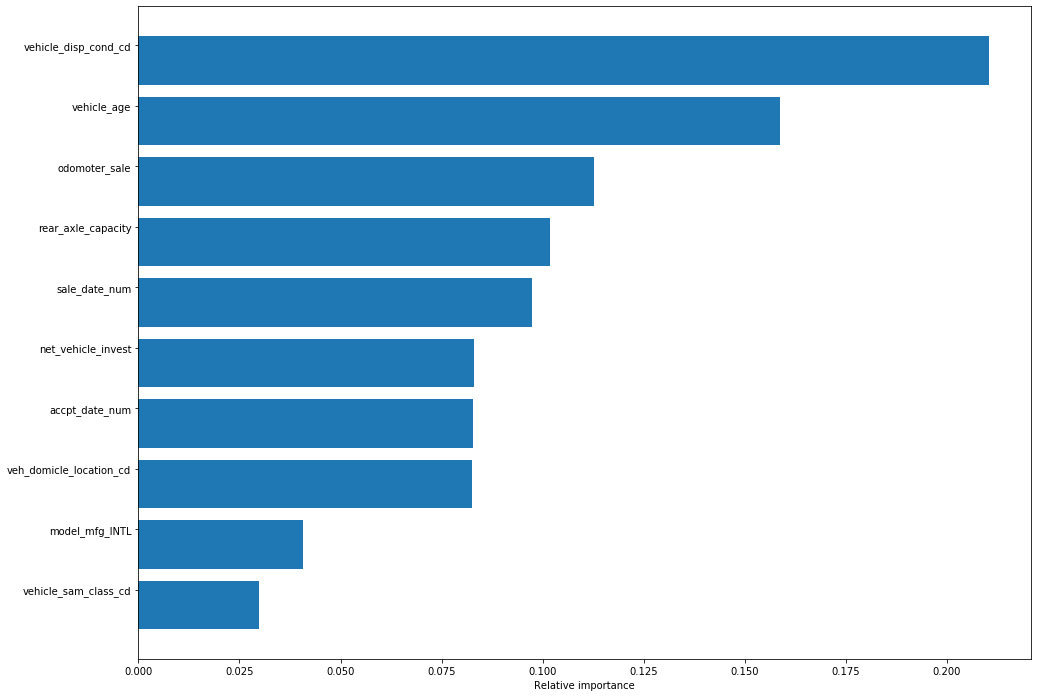

In [33]:
names2 = X2.columns #variables.values
# sort importances
indices2 = np.argsort(model_gbr2.feature_importances_)
# plot as bar chart
figure(figsize=(16,12))
plt.barh(np.arange(len(names2)), model_gbr2.feature_importances_[indices2])
plt.yticks(np.arange(len(names2)) + 0.25, np.array(names2)[indices2])
_ = plt.xlabel('Relative importance')
print(names2)

### Step 7: Check Prediction vs. Actual values

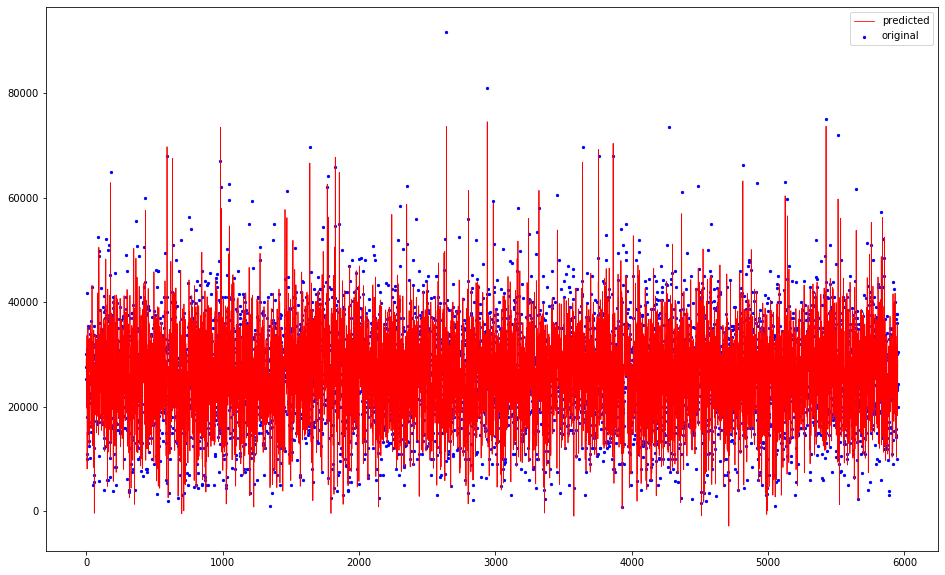

<Figure size 1152x720 with 0 Axes>

In [34]:
x_ax2 = range(len(y_test2))
plt.figure(figsize=(16,10))
plt.scatter(x_ax2, y_test2, s=5, color="blue", label="original")
plt.plot(x_ax2, model_gbr2.predict(X_test2), lw=0.8, color="red", label="predicted")
plt.legend()
figure(figsize=(16,10))
plt.show()

### Plot Deviance

Text(0, 0.5, 'Deviance')

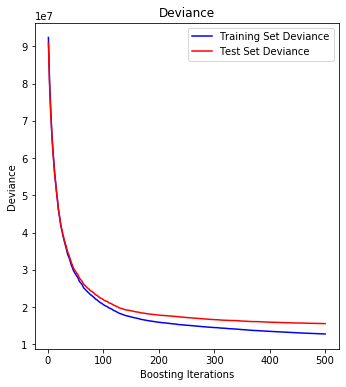

In [35]:
test_score2 = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred2 in enumerate(model_gbr2.staged_predict(X_test2)):
    test_score2[i] = model_gbr2.loss_(y_test2, y_pred2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model_gbr2.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score2, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Alternative Library (Faster, but BETA) - HistGradientBoostingRegressor

In [36]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting # now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

model_hgbr = HistGradientBoostingRegressor(max_depth=6, loss='least_squares')
model_hgbr.fit(X_train, y_train)
# predict class labels
predict_hgbr = model_hgbr.predict(X_test)

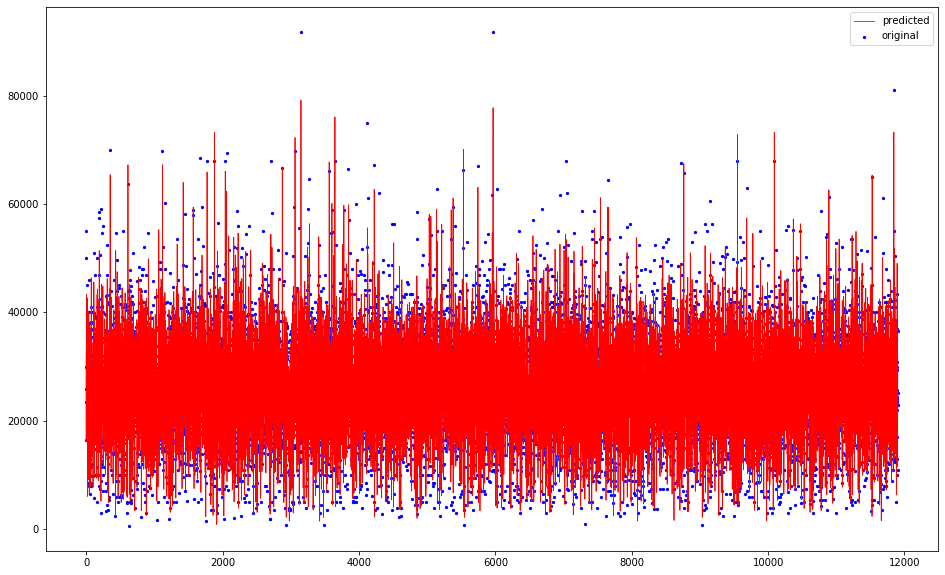

<Figure size 1152x720 with 0 Axes>

In [37]:
x_ax3 = range(len(y_test))
plt.figure(figsize=(16,10))
plt.scatter(x_ax3, y_test, s=5, color="blue", label="original")
plt.plot(x_ax3, model_hgbr.predict(X_test), lw=0.8, color="red", label="predicted",)
plt.legend()
figure(figsize=(16,10))
plt.show()

In [38]:
MAE["HGBR_ALL"] = mean_absolute_error(y_test, model_hgbr.predict(X_test))
MSE["HGBR_ALL"] = mean_squared_error(y_test, model_hgbr.predict(X_test))
SCORE["HGBR_ALL"] = model_hgbr.score(X_test, y_test)
print('MAE: %.4f' % MAE["HGBR_ALL"])
print('MSE: %.4f' % MSE["HGBR_ALL"])
print('Accuracy: %.4f' % SCORE["HGBR_ALL"])

MAE: 2735.7176
MSE: 14160410.9820
Accuracy: 0.8579


### HistGradientBoostingRegressor - Top Features Only

In [39]:
model_hgbr2 = HistGradientBoostingRegressor(max_depth=6, loss='least_squares')
model_hgbr2.fit(X_train2, y_train2)
predict_hgbr2 = model_hgbr2.predict(X_test2)

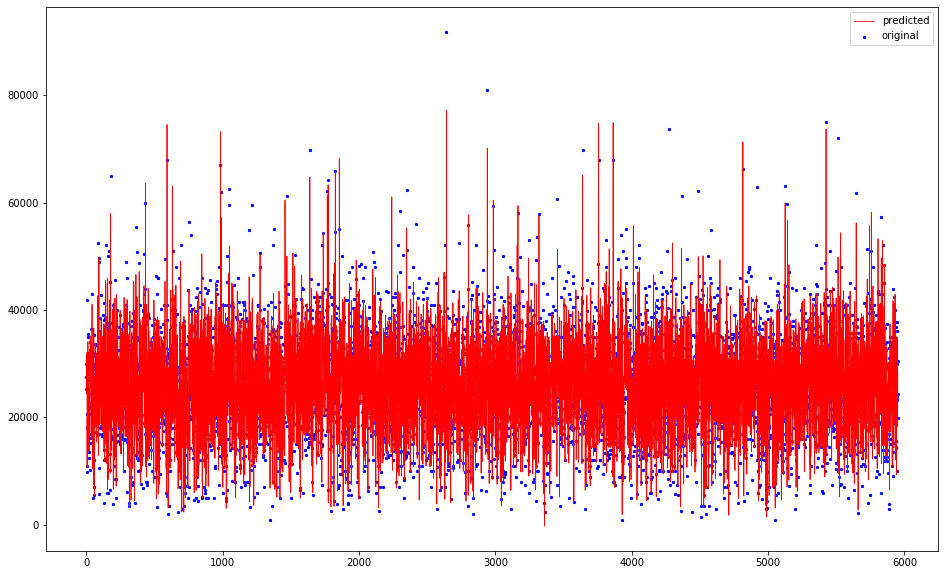

<Figure size 1152x720 with 0 Axes>

In [40]:
x_ax4 = range(len(y_test2))
plt.figure(figsize=(16,10))
plt.scatter(x_ax4, y_test2, s=5, color="blue", label="original")
plt.plot(x_ax4, model_hgbr2.predict(X_test2), lw=0.8, color="red", label="predicted",)
plt.legend()
figure(figsize=(16,10))
plt.show()

In [41]:
MAE["HGBR_TOP"] = mean_absolute_error(y_test2, model_hgbr2.predict(X_test2))
MSE["HGBR_TOP"] = mean_squared_error(y_test2, model_hgbr2.predict(X_test2))
SCORE["HGBR_TOP"] = model_hgbr2.score(X_test2, y_test2)
print('MAE: %.4f' % MAE["HGBR_TOP"])
print('MSE: %.4f' % MSE["HGBR_TOP"])
print('Accuracy: %.4f' % SCORE["HGBR_TOP"])

MAE: 2788.7625
MSE: 15469853.9671
Accuracy: 0.8421


## XGBoost

In [42]:
#import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=500,
                             learning_rate = 0.3,
                             objective ='reg:squarederror', #regression with squared loss.
                             subsample=0.5, 
                             max_depth=6,
                             tree_method='auto')

model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, tree_method='auto',
             verbosity=1)

In [43]:
predictions = model_xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8343997408688882


In [44]:
#!pip install graphviz --user
xgb.plot_tree(model_xgb, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(500, 250)

plt.show()

In [45]:
dump_list = model_xgb.get_booster().get_dump()
num_trees = len(dump_list)
print(num_trees)

500


In [46]:
# from sklearn.model_selection import StratifiedKFold
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.2, 0.3], #so called `eta` value
#               'max_depth': [3,4,5,6],
#               'subsample':[0.5],
#               'n_estimators': [100,300,500]}

# learning_rate = [0.03, 0.05, 0.07, 0.1, 0.2, 0.3]
# model_xgb2 = xgb.XGBRegressor()

# #param_grid = dict(learning_rate=learning_rate)
# param_grid = parameters
# #kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model_xgb2, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=5)#cv=kfold)
# grid_result = grid_search.fit(X_train,y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Output from previous cell:

`Best: 
-11472426.060482 using 
{'learning_rate': 0.07, 
'max_depth': 6, 
'n_estimators': 500, 
'nthread': 4, 
'objective': 'reg:squarederror', 
'subsample': 0.5}`

In [47]:
#import xgboost as xgb
model_xgb2 = xgb.XGBRegressor(n_estimators=500,
                             learning_rate = 0.07,
                             objective ='reg:squarederror', #regression with squared loss.
                             subsample=0.5, 
                             max_depth=6,
                             tree_method='auto')

model_xgb2.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, tree_method='auto',
             verbosity=1)

In [48]:
predictions = model_xgb2.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8594023552461382


In [49]:
MAE["XBoost_ALL"] = mean_absolute_error(y_test, model_xgb2.predict(X_test))
MSE["XBoost_ALL"] = mean_squared_error(y_test, model_xgb2.predict(X_test))
SCORE["XBoost_ALL"] = model_xgb2.score(X_test, y_test)
print('MAE: %.4f' % MAE["XBoost_ALL"])
print('MSE: %.4f' % MSE["XBoost_ALL"])
print('Accuracy: %.4f' % SCORE["XBoost_ALL"])

MAE: 2420.6280
MSE: 11732218.2085
Accuracy: 0.8822


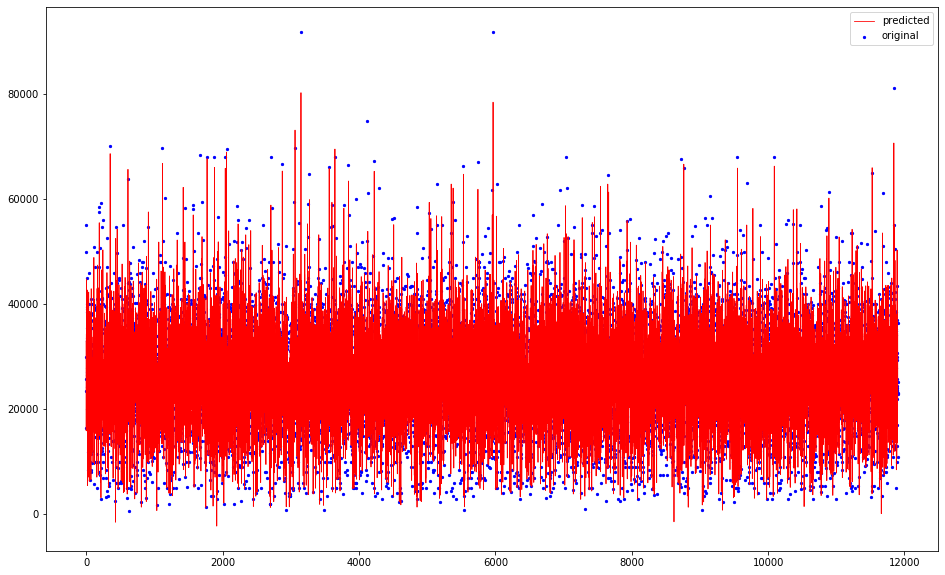

In [50]:
x_ax5 = range(len(y_test))
plt.figure(figsize=(16,10))
plt.scatter(x_ax5, y_test, s=5, color="blue", label="original")
plt.plot(x_ax5, model_xgb2.predict(X_test), lw=0.8, color="red", label="predicted",)
plt.legend()
plt.show()

In [51]:
model_xgb2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, tree_method='auto',
             verbosity=1)

In [52]:
xgb.plot_tree(model_xgb2, num_trees=499)
fig = plt.gcf()
fig.set_size_inches(500, 250)

plt.show()

## Light GBM

Light GBM is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. 

So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.

In [53]:
# from sklearn.metrics import make_scorer
# score_func = make_scorer(mean_absolute_error, greater_is_better=False)

# LGBM_model = lgb.LGBMRegressor( 
#     boosting_type="gbdt",
#     objective='regression',
#     is_unbalance=True, 
#     random_state=10, 
#     n_estimators=100,
#     num_leaves=30, 
#     max_depth=6,
#     feature_fraction=0.5,  
#     bagging_fraction=0.8, 
#     bagging_freq=15, 
#     learning_rate=0.01,   
# )

# params_opt = {'n_estimators':range(100, 500, 100),  # range(start, stop, step)
#               'num_leaves':range(20,100,10),
#               'max_depth' :[3,4,5,6,7,8],
#               'learning_rate':[0.03, 0.05, 0.07, 0.1, 0.2, 0.3]
#              }
# gridSearchCV = GridSearchCV(estimator = LGBM_model, 
#                             param_grid = params_opt, 
#                             scoring="neg_mean_squared_error", 
#                             n_jobs=-1, cv=5)
# grid_result = gridSearchCV.fit(X_train,y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Output from previous cell

`Best: 
-11019515.967640 using 
{'learning_rate': 0.1, 
'max_depth': 8, 
'n_estimators': 400, 
'num_leaves': 60}`


Model Details:

`
GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=15,
                                     boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, feature_fraction=0.5,
                                     importance_type='split', is_unbalance=True,
                                     learning_rate=0.01, max_depth=6,
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_job...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': range(100, 500, 100),
                         'num_leaves': range(20, 100, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)
`

In [54]:
model_LGBMR = lgb.LGBMRegressor(n_estimators=400,
                             learning_rate = 0.1,
                             max_depth=8,
                             num_leaves=60,
                             scoring='neg_mean_squared_error',
                             bagging_fraction=0.8, bagging_freq=15,
                             boosting_type='gbdt', class_weight=None,
                             colsample_bytree=1.0, feature_fraction=0.5,
                             importance_type='split', 
                              is_unbalance=True,)

model_LGBMR.fit(X_train,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=15, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', is_unbalance=True, learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=400, n_jobs=-1, num_leaves=60,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              scoring='neg_mean_squared_error', silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [55]:
predictions = model_LGBMR.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8605095190032376


In [56]:
MAE["LGBMR_ALL"] = mean_absolute_error(y_test, model_LGBMR.predict(X_test))
MSE["LGBMR_ALL"] = mean_squared_error(y_test, model_LGBMR.predict(X_test))
SCORE["LGBMR_ALL"] = model_LGBMR.score(X_test, y_test)
print('MAE: %.4f' % MAE["LGBMR_ALL"])
print('MSE: %.4f' % MSE["LGBMR_ALL"])
print('Accuracy: %.4f' % SCORE["LGBMR_ALL"])

MAE: 2427.6822
MSE: 11753137.8634
Accuracy: 0.8820


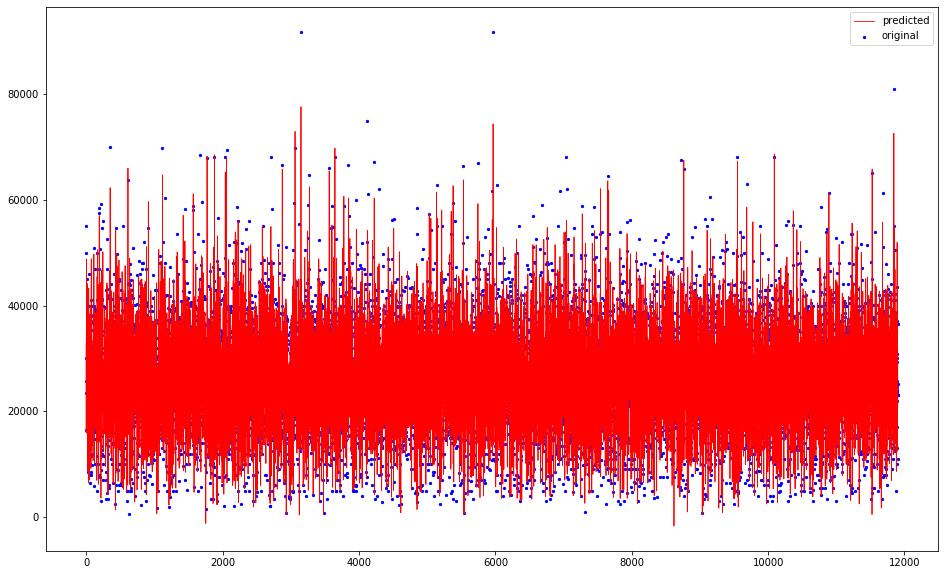

In [57]:
x_ax6 = range(len(y_test))
plt.figure(figsize=(16,10))
plt.scatter(x_ax6, y_test, s=5, color="blue", label="original")
plt.plot(x_ax6, model_LGBMR.predict(X_test), lw=0.8, color="red", label="predicted",)
plt.legend()
plt.show()

In [58]:
print('MODEL NAME\t\tSCORE\t\tMAE\t\tMSE')
for k, v in MAE.items():
    print("{}\t\t{}%\t\t{}\t\t{}".format(k,round(SCORE[k]*100),round(v),round(MSE[k])))

MODEL NAME		SCORE		MAE		MSE
GBRE_ALL		86.0%		2735.0		14230223.0
GBRE_TOP		84.0%		2851.0		15543217.0
HGBR_ALL		86.0%		2736.0		14160411.0
HGBR_TOP		84.0%		2789.0		15469854.0
XBoost_ALL		88.0%		2421.0		11732218.0
LGBMR_ALL		88.0%		2428.0		11753138.0


#### Using 33% Test and 66% Training Data

```
MODEL NAME		SCORE		MAE		MSE
GBRE_ALL		86.0%		2695.0		13663134.0
GBRE_TOP		83.0%		3029.0		16579864.0
HGBR_ALL		87.0%		2611.0		13036798.0
HGBR_TOP		84.0%		2977.0		16124492.0
XBoost_ALL		89.0%		2328.0		10575578.0
LGBMR_ALL		90.0%		2286.0		10385590.0

```

## Save best 3 models to disc

In [59]:
# Save Model Using Pickle

# save the model to disk
filename = '../../models/tractorXGBoost_ALL.model'
pickle.dump(model_xgb2, open(filename, 'wb'))

filename = '../../models/tractorLGBMR_ALL.model'
pickle.dump(model_LGBMR, open(filename, 'wb'))

filename = '../../models/tractorHGBR_ALL.model'
pickle.dump(model_hgbr, open(filename, 'wb'))

### Save EDA output data


In [60]:
filename = '../../data/df_tractorALL.pickle'
pickle.dump(df_main, open(filename, 'wb'))

In [61]:
df_main.columns.values

array(['accumulated_depreciation_amt', 'vehicle_sam_class_cd',
       'sam_summary_class_cd', 'veh_domicle_location_cd',
       'vehicle_disp_cond_cd', 'days_to_outservice', 'vehicle_age',
       'vehicle_gvw_class_cd', 'drive_tire_size_cd', 'rear_axle_capacity',
       'transmission_model_id', 'engine_model_id', 'engine_horsepower',
       'transmission_speed_qn', 'axle_total_count', 'net_vehicle_invest',
       'proceeds', 'model_year', 'odomoter_sale', 'accpt_date_num',
       'sale_date_num', 'suspension_type_cd_A', 'suspension_type_cd_L',
       'suspension_type_cd_T', 'transmission_manufacturer_cd_ALLI',
       'transmission_manufacturer_cd_FULL',
       'transmission_manufacturer_cd_OTHER', 'engine_manufacturer_cd_CAT',
       'engine_manufacturer_cd_CUMM', 'engine_manufacturer_cd_DETR',
       'engine_manufacturer_cd_INTL', 'engine_manufacturer_cd_OTHER',
       'model_mfg_FRTL', 'model_mfg_INTL', 'model_mfg_OTHER',
       'epa_tech_year_2002', 'epa_tech_year_2004', 'epa_tech_y